In [1]:
# Insert the directory
import sys
import os

path_to_helper = os.path.join(".", "src", "helper")
print(path_to_helper)
sys.path.insert(0,path_to_helper)
import helper as helper

.\src\helper


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np

# Load the dataset
data_path = r".\data\pneumonia_mnist\pneumoniamnist.npz"

npz_file = np.load(data_path)
print("Keys in the npz file:", npz_file.files)

Keys in the npz file: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [3]:
X_train = np.load(data_path)['train_images']
X_test = np.load(data_path)['test_images']
y_train = np.load(data_path)["train_labels"].reshape(-1)
y_test = np.load(data_path)["test_labels"].reshape(-1)

In [4]:
X_train.shape

(4708, 28, 28)

I will apply PCA to image data, to reduce the number of features (pixels) while retaining the most important information, to generate the features used in model training. Here, I'll used 95 percent of variance in the data.

In [5]:
from sklearn.decomposition import PCA
# PCA such that .95 percent of the variance is retained
pca = PCA(.95)
len_image_vector = X_train.shape[2] * X_train.shape[1]
pca.fit(X_train.reshape((X_train.shape[0],len_image_vector )))
X_train = pca.transform(X_train.reshape((X_train.shape[0],len_image_vector )))
X_test = pca.transform(X_test.reshape((X_test.shape[0],len_image_vector )))
print("The number of components for 95% variance is ",pca.n_components_)

The number of components for 95% varinace is  71


### Hyperparameter tuning

Pruning
 - Post pruning using cost complexity pruning
 - Prepruning by varying the max_depth parameter which varies the maximum depth of the tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
# Post pruning using cost complexity pruning

# Create an Decision Tree classifier with a radial basis function (RBF) kernel
clf = DecisionTreeClassifier(random_state = 0)
# Find the ccp_alpha values
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [8]:
# Define the hyperparameter names
param_names = ["ccp_alpha", 
               "max_depth", 
               "criterion", 
               "min_samples_split"]

# List of values to be explored for the hyperparameter
param_values = [ccp_alphas[:-1], # Excluding the trivial case of tree with no splits
                list(range(1, 9)), 
                ['gini', 'entropy', 'log_loss'],
                [0.02 * i for i in range(1, 11)]]

# Use a helper function 'train_clfs_with_hyperparameters' to train classifiers with different hyperparameter values
# DecisionTreeClassifier is the classifier being used
# 'param_name' is the name of the hyperparameter being tuned
# 'param_value' is the list of values to be explored for the hyperparameter
# 'X_train' is the training data
# 'y_train' is the corresponding labels

dct_clfs = [helper.train_clfs_with_hyperparameters(DecisionTreeClassifier, param_name, param_value, X_train, y_train) 
            for param_name, param_value in zip(param_names, param_values)]

### Plotting training and testing accuracies for bias and variance / overfit and underfit analysis

In [9]:
# Calculate training scores for classifiers trained with different hyperparameters
# 'dct_clfs' a list containing classifiers trained with different hyperparamters
# The score is calculated by the get_score method using the 'f1' criteria on the training data (X_train, y_train)

scoring = "accuracy"
train_scores_dct = [[helper.get_score(y_train,
                                     clf.predict(X_train), scoring, pos_label = 'M') 
                     for clf in dct_clf]
                    for dct_clf in dct_clfs]

# Calculate test scores for classifiers trained with different ccp_alpha values
# Similar to training scores calculation but using the testing data (X_test, y_test)
test_scores_dct = [[helper.get_score(y_test,
                                     clf.predict(X_test), scoring, pos_label = 'M') 
                     for clf in dct_clf]
                    for dct_clf in dct_clfs]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


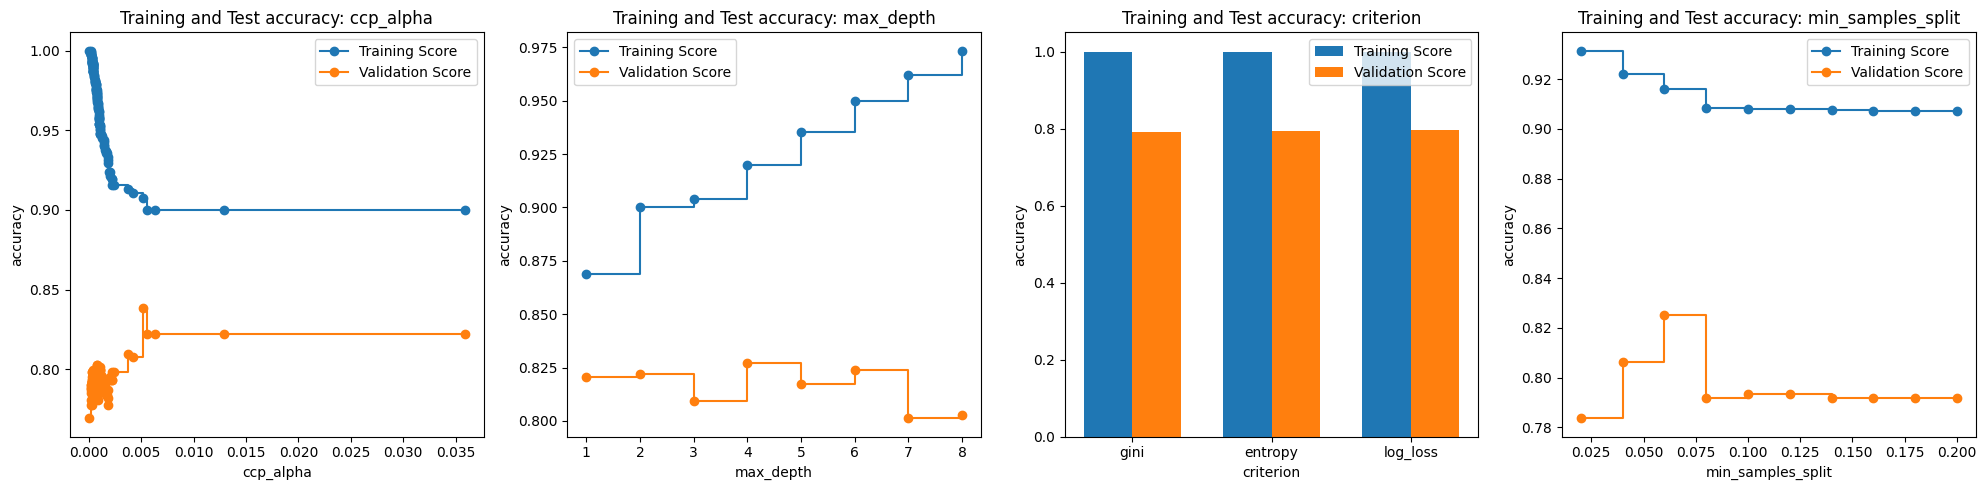

In [10]:
# Use a helper function 'plot_train_test_metrics' to visualize the training and test scores
# 'train_scores' and 'test_scores' contain the scores for each hyperparameter
# 'params' contains the range of values for each hyperparameter
# 'param_names' contains the names of the hyperparameters
# 'scoring' parameter specifies the scoring metric used for evaluation (e.g., 'Accuracy')
helper.plot_train_test_metrics(train_scores_dct, test_scores_dct, param_values, param_names, scoring='accuracy')

In [11]:
ccp_alphas[ccp_alphas>0.002]

array([0.00201433, 0.00217232, 0.00220351, 0.00224818, 0.00243053,
       0.0037196 , 0.00419761, 0.00519356, 0.00555881, 0.00633896,
       0.01293128, 0.03586629, 0.17203963])

### Tuning Model using GridSearch

In [12]:
# Use a helper function 'grid_search_func' to perform grid search over hyperparameters
# DecisionTreeClassifier() creates a Decision Tree classifier object
# 'param_values' contains the range of values for each hyperparameter
# 'param_names' contains the names of the hyperparameters
# 'cv=5' specifies 5-fold cross-validation for evaluation
# 'scoring='accuracy'' specifies that the 'accuracy' metric will be used for evaluation
# 'X_train', 'X_test', 'y_train', and 'y_test' contain the training and testing data
param_values = [ccp_alphas[ccp_alphas>0.002][:-1], # Excluding the trivial case of tree with no splits and the earlier ones that have lower accuracies
                list(range(1, 9)), 
                ['gini', 'entropy', 'log_loss'],
                [0.02 * i for i in range(1, 7)]]
result_dct = helper.grid_search_func(DecisionTreeClassifier(), 
                                     param_values, param_names,
                                     cv=5, scoring='accuracy', pos_label = "M",
                                     X_train=X_train, X_test=X_test,y_train=y_train, y_test=y_test, 
                                     verbose= 2 )

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best parameters: {'ccp_alpha': 0.0024305348948879964, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 0.02}
Test accuracy: 0.8269230769230769


DecisionTreeClassifier time: 0.0060 seconds
DecisionTreeClassifier time: 0.0051 seconds


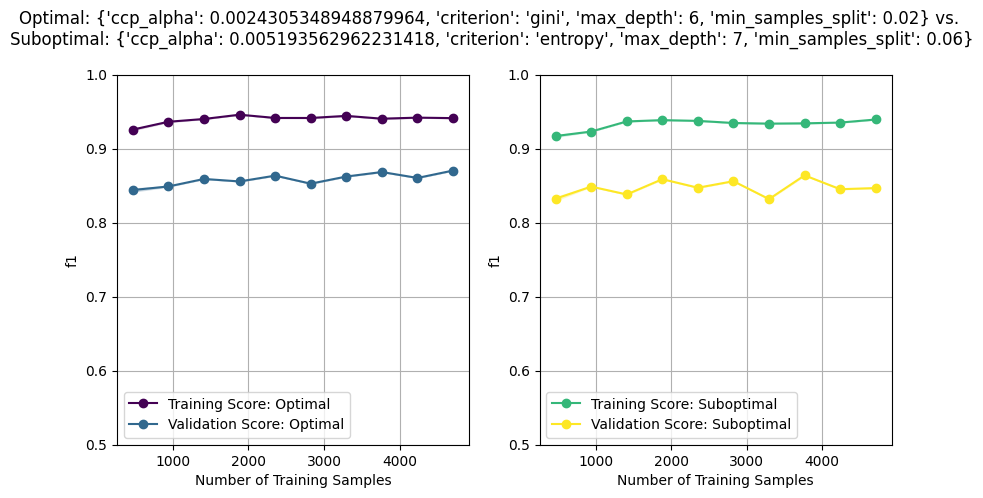

In [13]:
import pandas as pd
df_dct = pd.DataFrame(result_dct[1])
# Get best,suboptimal hyperparameter values
best_params = df_dct.sort_values(by="rank_test_score").iloc[0].params
suboptimal_params = df_dct.sort_values(by="rank_test_score").iloc[int(len(df_dct) / 2)].params

# Use a helper function 'plot_learning_curves' to visualize learning curves wrt sample size
# 'X_train', 'X_test', 'y_train', and 'y_test' contain the training and testing data
# 'clfs' is a list containing classifiers with different hyperparameters
# 'names' is a list containing names for classifier and parameters (for plotting)
# 'plot_train=False' specifies not to plot the training curves
# 'cv=10' specifies 10-fold cross-validation for evaluation
result = helper.plot_learning_curves(X_train, X_test, y_train, y_test, 
                     clfs=[DecisionTreeClassifier(**best_params),
                           DecisionTreeClassifier(**suboptimal_params)],
                     names=[f"Optimal: {best_params}", f"Suboptimal: {suboptimal_params}"],
                     plot_train=True,
                     cv=10, 
                     scoring = "f1",
                     pos_label = 1)

## Neural Networks

### Hyperparameter tuning


In a neural network classifier, there are several hyperparameters that can significantly impact the performance and behavior of the model. However, two of the most important hyperparameters are typically:

- Number of Hidden Layers and Neurons: The architecture of the neural network, including the number of hidden layers and the number of neurons in each layer, is crucial. A deeper network with more layers can capture complex relationships in the data, but it also increases the risk of overfitting, especially with limited data. Conversely, a shallow network may not have enough capacity to learn intricate patterns in the data. The number of neurons in each layer also affects the model's capacity to learn and its computational complexity.

- Learning Rate: The learning rate determines the step size at which the model parameters are updated during training. It controls the rate of convergence during training and influences how quickly or slowly the model learns. A high learning rate may cause the model to overshoot the optimal solution, leading to instability or divergence, while a low learning rate may result in slow convergence or getting stuck in local minima. Finding an appropriate learning rate is crucial for training neural networks effectively.

While these two hyperparameters are often considered among the most important, other factors such as activation functions, regularization techniques, batch size, and optimization algorithms also play significant roles in determining the performance of a neural network classifier. Experimentation and tuning across these parameters are typically necessary to achieve the best performance for a specific task.

In [ ]:
# Define the hyperparameter names
param_names = ["hidden_layer_sizes", 
               "activation"]

# List of values to be explored for the hyperparameter
param_values = [[[50 for _ in range(i)] for i in range(2, 13)],
                ['identity', 'logistic', 'tanh', 'relu']]


nn_clfs = [helper.train_clfs_with_hyperparameters(MLPClassifier, param_name, param_value, X_train, y_train) 
            for param_name, param_value in zip(param_names, param_values)]

## KNN CLassifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier

### Hyperparameter tuning


In a k-Nearest Neighbors (kNN) classifier, the two most important parameters are:

- Number of Neighbors (k): The choice of the number of neighbors, represented by the parameter 'k', is critical in kNN. It determines how many nearest neighbors to consider when making predictions for a new data point. Selecting an appropriate value for 'k' is essential because a small 'k' value may result in a noisy decision boundary, leading to overfitting, while a large 'k' value may cause the model to be overly biased and ignore local patterns in the data.

- Distance Metric: The choice of distance metric is also crucial in kNN, as it determines how the distance between data points is measured. The most commonly used distance metrics are Euclidean distance and Manhattan distance, but other options like Minkowski distance and cosine similarity may also be suitable depending on the nature of the data. Selecting the appropriate distance metric is essential for accurately capturing the similarity between data points and ensuring the effectiveness of the kNN algorithm.

These two parameters, the number of neighbors ('k') and the distance metric, significantly impact the performance of a kNN classifier. It's important to experiment with different values for these parameters and potentially perform hyperparameter tuning to find the optimal combination for a given dataset and classification task.

In [27]:
# Define the hyperparameter names
param_names = ["n_neighbors", 
               "metric"]

# List of values to be explored for the hyperparameter
param_values = [list(range(2, 30, 2)), 
                ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'nan_euclidean']]


knn_clfs = [helper.train_clfs_with_hyperparameters(KNeighborsClassifier, param_name, param_value, X_train, y_train) 
            for param_name, param_value in zip(param_names, param_values)]

### Plotting training and testing accuracies for bias and variance / overfit and underfit analysis

In [29]:
# Calculate training scores for classifiers trained with different hyperparameters
# 'dct_clfs' a list containing classifiers trained with different hyperparamters
# The score is calculated by the get_score method using the 'f1' criteria on the training data (X_train, y_train)

scoring = "f1"
train_scores_knn = [[helper.get_score(y_train,
                                     clf.predict(X_train), scoring, pos_label = 1) 
                     for clf in knn_clf]
                    for knn_clf in knn_clfs]

# Calculate test scores for classifiers trained with different ccp_alpha values
# Similar to training scores calculation but using the testing data (X_test, y_test)
test_scores_knn = [[helper.get_score(y_test,
                                     clf.predict(X_test), scoring, pos_label = 1) 
                     for clf in knn_clf]
                    for knn_clf in knn_clfs]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


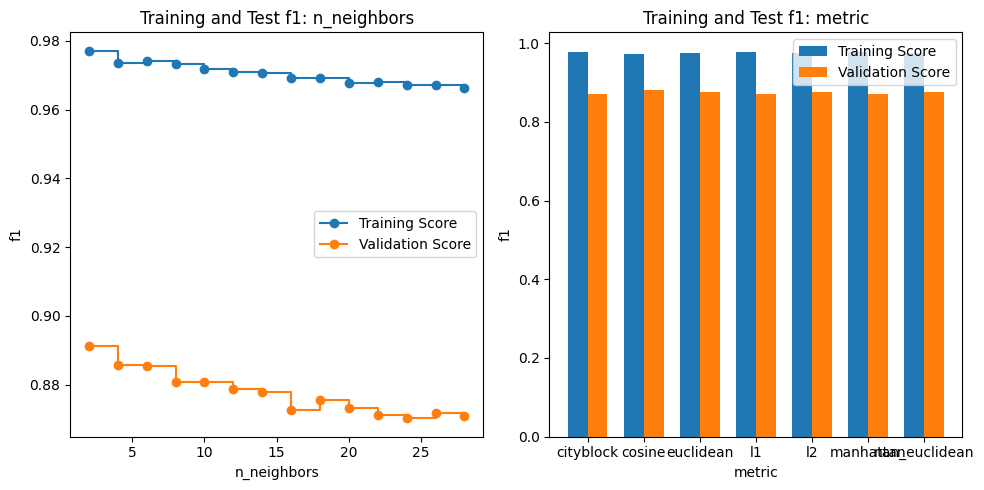

In [30]:
helper.plot_train_test_metrics(train_scores_knn, test_scores_knn, param_values, param_names, scoring='f1')

In [32]:
# Use a helper function 'grid_search_func' to perform grid search over hyperparameters
result_knn = helper.grid_search_func(KNeighborsClassifier(), 
                                     param_values, param_names,
                                     cv=5, scoring='f1', pos_label = 1,
                                     X_train=X_train, X_test=X_test,y_train=y_train, y_test=y_test, 
                                     verbose= 2 )

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Best parameters: {'metric': 'cityblock', 'n_neighbors': 18}
Test accuracy: 0.8744292237442922


KNeighborsClassifier time: 0.0860 seconds
KNeighborsClassifier time: 1.3666 seconds


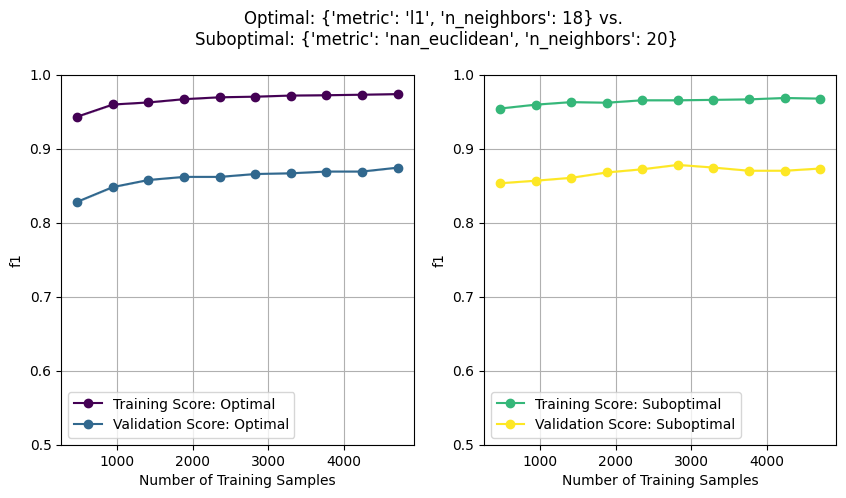

In [35]:
df_knn = pd.DataFrame(result_knn[1])

# Get best, worst and suboptimal hyperparameter values
best_params = df_knn.sort_values(by="rank_test_score").iloc[0].params
suboptimal_params = df_knn.sort_values(by="rank_test_score").iloc[int(len(df_knn) / 2)].params

# Use a helper function 'plot_learning_curves' to visualize learning curves wrt sample size
# 'X_train', 'X_test', 'y_train', and 'y_test' contain the training and testing data
# 'clfs' is a list containing classifiers with different hyperparameters
# 'names' is a list containing names for classifier and parameters (for plotting)
# 'plot_train=False' specifies not to plot the training curves
# 'cv=10' specifies 10-fold cross-validation for evaluation
result = helper.plot_learning_curves(X_train, X_test, y_train, y_test, 
                     clfs=[KNeighborsClassifier(**best_params),
                           KNeighborsClassifier(**suboptimal_params),],
                     names=[f"Optimal: {best_params}", f"Suboptimal: {suboptimal_params}"],
                     plot_train=True,
                     cv=10, 
                     scoring = "f1",
                     pos_label = 1)

## Support Vector Machines

In [36]:
from sklearn.svm import SVC

### Hyperparameter Tuning


In support vector classifiers (SVC), two of the most important hyperparameters are:

- C: This hyperparameter controls the trade-off between maximizing the margin and minimizing the classification error. A smaller value of C leads to a larger margin but may misclassify some training points, while a larger value of C allows for fewer misclassifications but may result in a smaller margin. Tuning C is crucial for controlling the balance between bias and variance in the model.

- Kernel choice and its parameters: SVC can use different types of kernels (e.g., linear, polynomial, radial basis function (RBF), sigmoid) to transform the input space into a higher-dimensional feature space where the data might be more separable. The choice of kernel and its associated parameters (e.g., degree for polynomial kernel, gamma for RBF kernel) significantly affect the model's performance. For example, the RBF kernel's gamma parameter controls the influence of individual training samples, while the polynomial kernel's degree parameter determines the degree of the polynomial used in the transformation.

Optimizing these hyperparameters through techniques like grid search or randomized search is essential to achieve the best performance of an SVC model for a given dataset.

In [37]:
# Define the hyperparameter names
param_names = ["C", 
               "kernel"]

# List of values to be explored for the hyperparameter
param_values = [[item for sublist in  [[0.01 * 10 ** i, 0.05 * 10 ** i ] for i in range(3)] for item in sublist],
                ['linear', 'poly', 'sigmoid', 'rbf']]


svc_clfs = [helper.train_clfs_with_hyperparameters(SVC, param_name, param_value, X_train, y_train) 
            for param_name, param_value in zip(param_names, param_values)]

### Plotting training and testing accuracies for bias and variance / overfit and underfit analysis


In [ ]:
# Calculate training scores for classifiers trained with different hyperparameters
# 'dct_clfs' a list containing classifiers trained with different hyperparamters
# The score is calculated by the get_score method using the 'f1' criteria on the training data (X_train, y_train)

scoring = "f1"
train_scores_svc = [[helper.get_score(y_train,
                                     clf.predict(X_train), scoring, pos_label = 'M') 
                     for clf in svc_clf]
                    for svc_clf in svc_clfs]

# Calculate test scores for classifiers trained with different ccp_alpha values
# Similar to training scores calculation but using the testing data (X_test, y_test)
test_scores_svc = [[helper.get_score(y_test,
                                     clf.predict(X_test), scoring, pos_label = 'M') 
                     for clf in svc_clf]
                    for svc_clf in svc_clfs]

In [ ]:
helper.plot_train_test_metrics(train_scores_svc, test_scores_svc, param_values, param_names, scoring='f1')

In [ ]:
# Use a helper function 'grid_search_func' to perform grid search over hyperparameters
result_svc = helper.grid_search_func(SVC(), 
                                     param_values, param_names,
                                     cv=5, scoring='f1', pos_label = "M",
                                     X_train=X_train, X_test=X_test,y_train=y_train, y_test=y_test, 
                                     verbose= 2 )

In [ ]:
# Get best, worst and suboptimal hyperparameter values
df_svc = pd.DataFrame(result_svc[1])
best_params = df_svc.sort_values(by="rank_test_score").iloc[0].params
bad_params = df_svc.sort_values(by="rank_test_score").iloc[-6].params
suboptimal_params = df_svc.sort_values(by="rank_test_score").iloc[int(len(df_svc) / 2)].params

# Use a helper function 'plot_learning_curves' to visualize learning curves wrt sample size
# 'X_train', 'X_test', 'y_train', and 'y_test' contain the training and testing data
# 'clfs' is a list containing classifiers with different hyperparameters50820	0.935484	1.000000	0.95522
# 'names' is a list containing names for classifier and parameters (for plotting)
# 'plot_train=False' specifies not to plot the training curves
# 'cv=10' specifies 10-fold cross-validation for evaluation
result = helper.plot_learning_curves(X_train, X_test, y_train, y_test, 
                     clfs=[SVC(**best_params),
                           SVC(**suboptimal_params),
                           SVC(**bad_params),],
                     names=[f"Optimal: {best_params}", f"Suboptimal: {suboptimal_params}", f"Worst: {bad_params}"],
                     plot_train=True,
                     cv=10, 
                     scoring = "f1",
                     pos_label = "M")

## Boosting

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

### Hyperparamter tuning


In gradient boosting, there are several hyperparameters that play crucial roles in the performance and behavior of the model. Some of the most important hyperparameters include:

- n_estimators: This parameter defines the number of boosting stages (weak learners, typically decision trees) to be used in the ensemble. Increasing the number of estimators generally improves the model's performance, but it also increases computational complexity and the risk of overfitting.

- learning_rate: Also known as the shrinkage parameter (or eta), the learning rate controls the contribution of each tree to the final ensemble. Lower values require more boosting iterations but can improve generalization and robustness to overfitting.

- max_depth: This parameter determines the maximum depth of each individual decision tree in the ensemble. Deeper trees can capture more complex relationships in the data but may also lead to overfitting. Limiting the max_depth can help control the complexity of the model and improve generalization.

These are some of the key hyperparameters in gradient boosting, but there may be additional parameters depending on the specific implementation or variant of the algorithm. Tuning these hyperparameters through techniques like grid search or randomized search is essential for optimizing the model's performance on a given dataset.

In [11]:
# Define the hyperparameter names
param_names = ["n_estimators", 
               "learning_rate", 
               "max_depth"]

# List of values to be explored for the hyperparameter
param_values = [[item for sublist in  [[1 * 10 ** i, 5 * 10 ** i] for i in range(5)] for item in sublist], 
                [item for sublist in  [[0.005 * 10 ** i, 0.01 * 10 ** i] for i in range(4)] for item in sublist],
                list(range(1, 10))]

# Use a helper function 'train_clfs_with_hyperparameters' to train classifiers with different hyperparameter values
# DecisionTreeClassifier is the classifier being used
# 'param_name' is the name of the hyperparameter being tuned
# 'param_value' is the list of values to be explored for the hyperparameter
# 'X_train' is the training data
# 'y_train' is the corresponding labels

gbc_clfs = [helper.train_clfs_with_hyperparameters(GradientBoostingClassifier, param_name, param_value, X_train, y_train) 
            for param_name, param_value in zip(param_names, param_values)]

### Plotting training and testing accuracies for bias and variance / overfit and underfit analysis

In [12]:
# Calculate training scores for classifiers trained with different hyperparameters
# 'dct_clfs' a list containing classifiers trained with different hyperparamters
# The score is calculated by the get_score method using the 'f1' criteria on the training data (X_train, y_train)

scoring = "f1"
train_scores_gbc = [[helper.get_score(y_train,
                                     clf.predict(X_train), scoring, pos_label = 1) 
                     for clf in gbc_clf]
                    for gbc_clf in gbc_clfs]

# Calculate test scores for classifiers trained with different ccp_alpha values
# Similar to training scores calculation but using the testing data (X_test, y_test)
test_scores_gbc = [[helper.get_score(y_test,
                                     clf.predict(X_test), scoring, pos_label = 1) 
                     for clf in gbc_clf]
                    for gbc_clf in gbc_clfs]

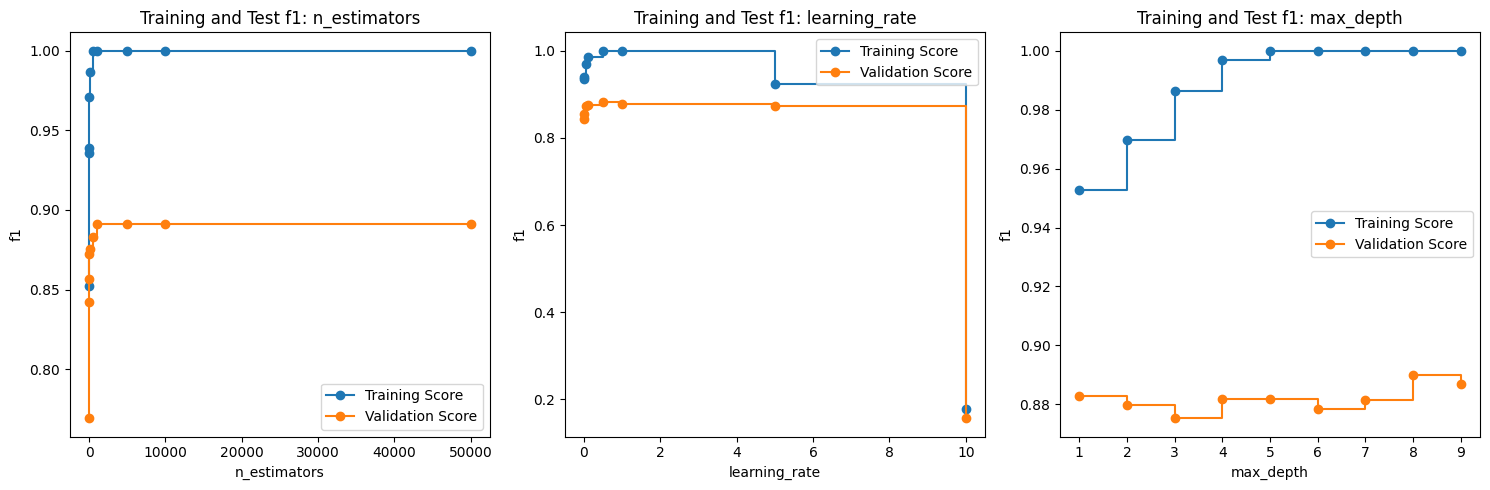

In [13]:
# 'scoring' parameter specifies the scoring metric used for evaluation (e.g., 'Accuracy')
helper.plot_train_test_metrics(train_scores_gbc, test_scores_gbc, param_values, param_names, scoring='f1')

In [14]:
# Use a helper function 'grid_search_func' to perform grid search over hyperparameters
# DecisionTreeClassifier() creates a Decision Tree classifier object
# 'param_values' contains the range of values for each hyperparameter
# 'param_names' contains the names of the hyperparameters
# 'cv=5' specifies 5-fold cross-validation for evaluation
# 'scoring='f1'' specifies that the 'f1' metric will be used for evaluation
# 'X_train', 'X_test', 'y_train', and 'y_test' contain the training and testing data

param_values = [[item for sublist in  [[1 * 10 ** i, 5 * 10 ** i] for i in range(2, 4)] for item in sublist], 
                [item for sublist in  [[0.005 * 10 ** i, 0.01 * 10 ** i] for i in range(3)] for item in sublist],
                list(range(4, 12))]


result_gbc = helper.grid_search_func(GradientBoostingClassifier(), 
                                     param_values, param_names,
                                     cv=5, scoring='f1', pos_label = 1,
                                     X_train=X_train, X_test=X_test,y_train=y_train, y_test=y_test, 
                                     verbose= 2 )

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 500}
Test accuracy: 0.881199538638985


GradientBoostingClassifier time: 0.0359 seconds
GradientBoostingClassifier time: 0.0060 seconds


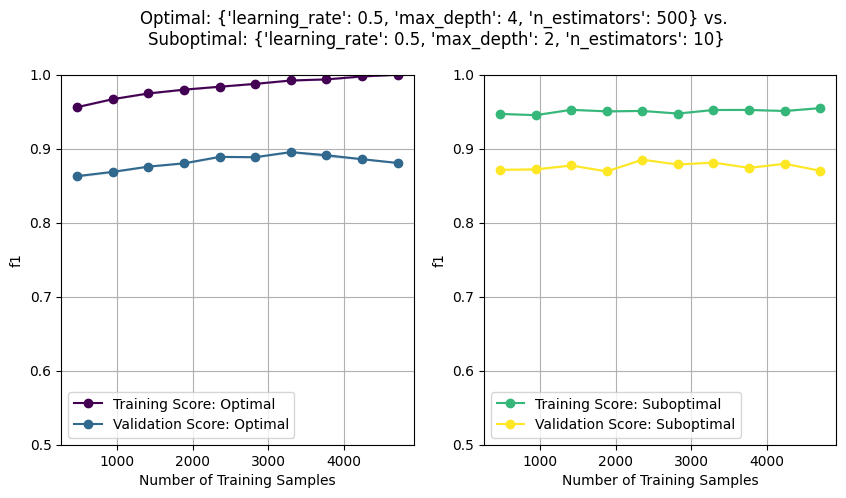

In [27]:
# Get best, worst and suboptimal hyperparameter values
import pandas as pd
df_gbc = pd.DataFrame(result_gbc[1])
best_params = df_gbc.sort_values(by="rank_test_score").iloc[0].params
suboptimal_params = {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 10}

# Use a helper function 'plot_learning_curves' to visualize learning curves wrt sample size
# 'X_train', 'X_test', 'y_train', and 'y_test' contain the training and testing data
# 'clfs' is a list containing classifiers with different hyperparameters50820	0.935484	1.000000	0.95522
# 'names' is a list containing names for classifier and parameters (for plotting)
# 'plot_train=False' specifies not to plot the training curves
# 'cv=10' specifies 10-fold cross-validation for evaluation
result = helper.plot_learning_curves(X_train, X_test, y_train, y_test, 
                     clfs=[GradientBoostingClassifier(**best_params),
                           GradientBoostingClassifier(**suboptimal_params)],
                     names=[f"Optimal: {best_params}", f"Suboptimal: {suboptimal_params}"],
                     plot_train=True,
                     cv=10, 
                     scoring = "f1",
                     pos_label = 1)

In [24]:
df_gbc.sort_values(by="rank_test_score")["params"].iloc[-1]

{'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 100}